# Extreme Multi Label Classification: International Patent classification

Patents are classified according to the International Patent classification in 8 sections, 129 classes, 639 subclasses, 7314 main groups and 61397 subgroups. 
In the data extraction notebook, we decide to work with up to 5 labels per patent and we stopped at the subclasses level, thus our algorithm will have to classify up to 5 labels per patent in 639 classes, which seemed to me a sufficient level of difficulty for first experiments.
I decided to go with the architecture describes in 
<a href="http://nyc.lti.cs.cmu.edu/yiming/Publications/jliu-sigir17.pdf"> the following publication</a> called XML-CNN. 

XML-CNN offers the undeniable advantage of convolution networks, a fast learning process on large datasets. In fact, the final architecture is a feed-forward neural network, so all the calculations can be parallelized on the GPU, which saves us up to 1,000 orders of magnitude in terms of computing time. So it will train incredible faster than recurrent neural networks. 
And what about transformer models ? 
Transformers models have a O(n^3) complexity, so the input length is often limited to less than 1000 tokens,whereas XML-CNN can take large input data ! And fortunately because patent can have corpora of more than 50000 words.

(PS: There exist multiple workarounds to transformers limited input length, you can check my work on that in the <a href="">following repo</a>)


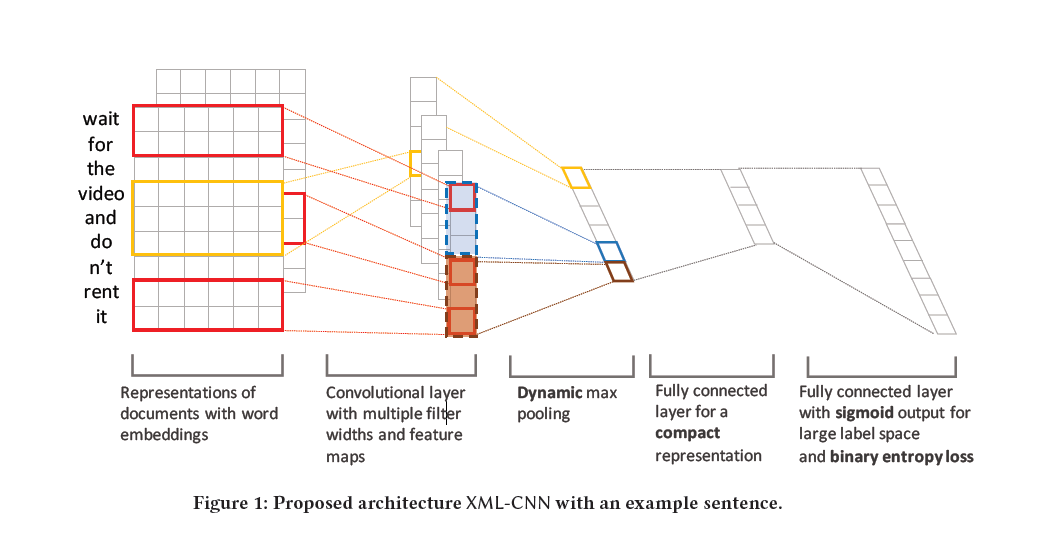


The network takes the text as input, and applies multiple convolution filters of different sizes to the text to capture more or less context and more or less detail. 
These filters are then concatenated, in order to then apply a layer of "dynamic max pooling". The information is condensed into a small layer before reaching the large output layer due to the large number of classes. The goal is to reduce the computational cost and increase the abstraction capacity of the model. 


### Table of Contents

* [Retrieve Data](#chapter1)
    * [Load Data from Pickle](#section_1_1)
    * [Split the Data !](#Section_1_2)
    * [Format Data](#Section_1_3)
* [Embedding Layer](#chapter2)
* [Model](#chapter3)
    * [Model definition](#section_3_1)
    * [Model Summary](#section_3_2)
    * [Metrics](#section_3_3)
    * [Callbacks](#section_3_4)
    * [Training](#section_3_5)
* [Evaluate test data](#chapter4)
    * [Evaluation metrics](#section_4_1)
        * [Choice of threshold](#section_4_1_1)
        * [Custom metric](#section_4_1_2)
        * [Recall and Precision](#section_4_1_3)
        * [Various metric experimentations](#section_4_1_4)
* [Conclusion](#chapter5)
        
   
    

In [1]:
import sys
import os
import pickle
import numpy as np
import pandas as pd
import random
import h5py
import csv
import json
import time
import string
import datetime as dt
import matplotlib.pyplot as plt
import re
random_state_number = 967898

In [2]:
import tensorflow as tf
print(tf.__version__)


2.1.0


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6397620588285452658
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6574135706
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1279898225595648976
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


## Data <a class="anchor" id="chapter1"></a>

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### Load Data from Pickle <a class="anchor" id="section_1_1"></a>

In [20]:
with open ('./MultiLabelData/df_test_clean_final_multilabel.pickle','rb') as fichier:
    df_test = pickle.load(fichier)

with open ('./MultiLabelData/df_train_clean_final_multilabel.pickle','rb') as fichier:
    df = pickle.load(fichier)


In [ ]:
with open ('./MultiLabelData/CIB_to_Labels.pickle','rb') as fichier:
    CIB_to_Labels = pickle.load(fichier)


### Split the data ! <a class="anchor" id="section_1_2"></a>

In [21]:

df = df[:3000000]
train_size = 0.8
df_train = df.sample(frac=train_size, random_state=200)
df_dev = df.drop(df_train.index).reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(df_train.shape))
print("DEV Dataset: {}".format(df_dev.shape))

FULL Dataset: (3000000, 8)
TRAIN Dataset: (2400000, 8)
DEV Dataset: (600000, 8)


In [22]:
print("Training data frame : ..." )
print(df_train.head())
print('\n')
print("Test data frame : ..." )
print(df_test.head())

Training data frame : ...
  Patent_number CIB_1 CIB_2 CIB_3 CIB_4 CIB_5  \
0     FR3830538  H01L  H01L  H05B  H05B  None   
1     FR4649520  G01J  G01J  None  None  None   
2     FR3701793  G06F  None  None  None  None   
3     FR1311517  C05G  C05G  C05D  None  None   
4     FR4550273  H04B  H04B  None  None  None   

                                                text                cat  
0  applicateur champ plaques parallèles assisté m...  [14, 14, 2, 2, 2]  
1  detecteur bolometrique a polarisation adaptati...           [70, 70]  
2  cadriciel extension isolement élastiques multi...                [0]  
3  procede traitement dechets biologiques présent...    [457, 457, 456]  
4  autoradio comprenant premiere chaine reception...         [101, 101]  


Test data frame : ...
  Patent_number CIB_1 CIB_2 CIB_3 CIB_4 CIB_5  \
0     FR1706257  G01T  A61B  G01T  A61B  H01L   
1     FR2011487  C22C  C23C  C22C  C22C  None   
2     FR3804361  H04L  H04H  None  None  None   
3     FR3804376

In [ ]:
print("There are {} patents for testing".format(len(df_test)))
print("Number of class represented in test Data for CIB_1 only :{}".format(df_dev['CIB_1'].nunique()) + '\n')

print("There are {} patents for training ".format(len(df_train)))
print("Number of class represented in training Data for CIB_1 only :{}".format(df_train['CIB_1'].nunique()) )


In [23]:
print("Number of labels :{}".format(len(CIB_to_Labels)))

Number of labels :637


### Format Data <a class="anchor" id="section_1_3"></a>

We decided to work with french word embeddings found on the internet. Those have and embedding size of 300. Thanks to our previous work on the data, looking at the length distribution of patents corpora, we noticed that truncationg at 1500 words would be sufficient.
Why are there so few words in those texts ? The text data that we have only contains the abstract of the patents. 

In [24]:
WORD_EMB_SIZE = 300
MAX_TEXT_LEN = 1500
NUMBER_OF_LABELS = 637

The function multi_label_one_hot is a custom function to encode our labels [14,16,0] in a one hot vector:
[1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,....,0]

In [25]:
def multi_label_one_hot(cats):
    labels = []
    for cat in cats:
        one_hot_cat = np.zeros(NUMBER_OF_LABELS, dtype='bool')
        for k in cat:
            one_hot_cat[k] = 1
        labels.append(one_hot_cat)
    return np.array(labels, dtype='bool')
        

In [26]:
def seqAndPad(text,max_length, tokenizer):
    
    sequences = tokenizer.texts_to_sequences(text)
    del text
    data = pad_sequences(sequences, maxlen=max_length,
                         padding='post', truncating='post')
    del sequences
    return(data)

def truncate(text, max_length):
    for o, doc in enumerate(text):
        text[o]= " ".join(text[o].split()[:max_length])
    return(text)


def formatTextData (df_train, df_test,max_length):
    '''
    max_length : tronquer les abstracts
    max_num_words : dans le tokenizer, si un mot est trop fréquent, il est supprimé
    '''
    text_train = df_train['text'].tolist()
    text_test = df_test['text'].tolist()
    
    print("Truncating text data to max_length")
    
    text_train = truncate(text_train, max_length)
    text_test = truncate(text_test, max_length)
    
    print("Tokenizing data...")
    tokenizer = Tokenizer(oov_token="<OOV>")
    tokenizer.fit_on_texts(text_train + text_test)
    print("Tokenizing done")
    print("Sequencing and padding...")
    text_train = seqAndPad(text_train, max_length, tokenizer)
    text_test = seqAndPad(text_test, max_length, tokenizer)
    print("Sequencing and padding done")
    
    
    y_train = multi_label_one_hot(df_train['cat'].tolist())
    y_test = multi_label_one_hot(df_test['cat'].tolist())
    
    
    return (text_train, y_train, text_test, y_test, tokenizer)
    



In [28]:
x_train, y_train, x_test, y_test, tokenizer = formatTextData(df_train,
                                                             df_dev, 
                                                             max_length = MAX_TEXT_LEN,
                                                             )

Truncating text data to max_length
Tokenizing data...
Tokenizing done
Sequencing and padding...
Sequencing and padding done


I grew tired of launching the cell above. Tokenizing large datasets can be very time consuming. So i decided to save the results.

In [29]:
with open (os.path.join('./MultiLabelData/', 'total_x_dev_clean_multilabel.pickle') , 'wb') as save:
    pickle.dump( (x_test,y_test) , save, protocol=4)

In [30]:
with open (os.path.join('./MultiLabelData/', 'total_x_train_clean_multilabel.pickle') , 'wb') as save:
    pickle.dump((x_train, y_train), save, protocol=4)

In [31]:
with open (os.path.join('./MultiLabelData/', 'tokenizer.pickle') , 'wb') as save:
    pickle.dump(tokenizer, save)

## Embedding Layer <a class="anchor" id="chapter2"></a>


We compute an index mapping words to known pre-trained embeddings, by parsing the data dump of pre-trained embeddings

In [32]:
vocab_size=len(tokenizer.word_index) + 1
print('Vocab_size is {}'.format(vocab_size))

Vocab_size is 570150


In [33]:
import gzip
import codecs
embeddings_index = {}
with codecs.getreader("utf-8")(gzip.open('./Embeddings/cc.fr.300.vec.gz', 'rb')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        emb = np.asarray( values[1:], dtype='float32')
        embeddings_index[word] = emb
print('Found {} word vectors'.format(len(embeddings_index)))

Found 2000000 word vectors


In [34]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, WORD_EMB_SIZE))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        #words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector
print('Embedding_matrix loaded')
print('Shape {}'.format(embedding_matrix.shape))

Embedding_matrix loaded
Shape (570150, 300)


## Model <a class="anchor" id="chapter3"></a>


In [35]:
from tensorflow.keras import backend as K

#from tensorflow.keras.engine import Layer, InputSpec, InputLayer

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Dropout, Embedding, concatenate
from tensorflow.keras.layers import Conv1D, MaxPool1D, Conv2D, MaxPool2D, ZeroPadding1D
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization
from tensorflow.keras.layers import Concatenate, Dot, Concatenate, Multiply, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.regularizers import l2

### Model definition <a class="anchor" id="section_3_1"></a>

CNN with Dynamic Max Pooling with sentences

In [72]:
""" Parameters """
FILTERS = 512
pooling_units = 1000
output_dims = 637
hidden_dims= 128

text_seq_input = Input(shape=(1500,), dtype='int32')
text_embedding = Embedding(vocab_size, WORD_EMB_SIZE, input_length=MAX_TEXT_LEN,
                            weights=[embedding_matrix], trainable=False)(text_seq_input)
text_dropout = Dropout(0.25)(text_embedding)

filter_sizes = [2,4,8]
convs = []
for filter_size in filter_sizes:
    l_conv = Conv1D(filters=FILTERS, kernel_size=filter_size, padding='same', activation='relu')(text_dropout)
    POOL_SIZE = l_conv.get_shape()[-2] // pooling_units
    l_pool = MaxPool1D(pool_size=POOL_SIZE, strides =2, padding='valid')(l_conv)   #Dynamic pooling
    convs.append(l_pool)

l_merge = Concatenate(axis=1)(convs)
l_cov1= Conv1D(1024, 5, activation='relu')(l_merge)
# since the text is too long we are maxooling over 100
# and not GlobalMaxPool1D
l_pool1 = MaxPool1D(100)(l_cov1)
l_flat = Flatten()(l_pool1)
l_hidden = Dense(hidden_dims, activation='relu')(l_flat)
l_hidden_drop = Dropout(0.5)(l_hidden)
l_out = Dense(output_dims, activation='sigmoid')(l_hidden_drop)  #dims output
model_1 = Model(inputs=[text_seq_input], outputs=l_out)

### Summary <a class="anchor" id="section_3_2"></a>

In [250]:
''' 
categorical cross-entropy : activation function en entrée c' est un softmax, i.e les scores se somment à 1 
alors que binary cross-entropy, c'est du sigmoid.
'''
preci = tf.keras.metrics.Precision(thresholds = 0.2)
recall = tf.keras.metrics.Recall(thresholds = 0.2)
#metric_top_k = tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_k_categorical_accuracy', dtype=None)
model_1.compile(loss='binary_crossentropy', optimizer=Adam(lr=1.5e-3), metrics=['categorical_accuracy', preci, recall, custom_metric])
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1500)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1500, 300)    171045000   input_2[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 1500, 300)    0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 1500, 512)    307712      dropout_2[0][0]                  
____________________________________________________________________________________________

### Custom Metrics definition <a class="anchor" id="section_3_3"></a>

I quite struggeld to evaluate de model. I setteled with 3 metrics :
- Recall : It allowed me to monitor if the model manages to capture the maximum of true positives
- Precision : Monitor if the model doesn't go berzerk and puts too many positive labels.
- A custom metric that measures the total number of patent on which the models at least gets one of their true positive labels. It allows me to track the overall number of patents on which the model predicted a good prediction.

Why those 3 metrics ? Because they are complementary. 
The custom metric is not very restrictive. I mean he could predict 20 positive labels on every patent, whereas there are max 5 labels and thus recall could be high (he gets a lot of true positives) but precision would be low. 
And as for the custom metric, he is partly described by the recall, but shows the overall performance. (if recall is high, the custom metric can't be too poor)

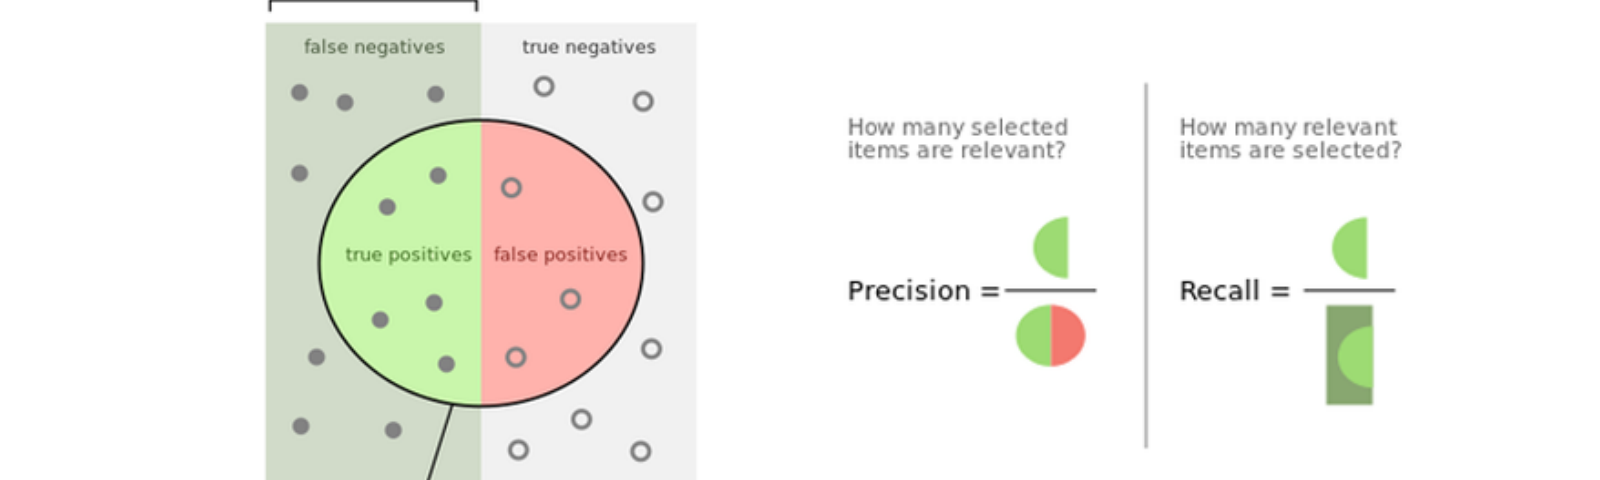

In [ ]:
def custom_metric(y_true,y_pred):
    y_true = tf.keras.backend.cast(y_true, dtype='float32')
    
    best = tf.keras.backend.argmax(y_pred, axis=-1)
    best = tf.keras.backend.one_hot(best,637)
    best = y_true*best
    best = tf.keras.backend.sum(best, axis=-1)
    return(tf.keras.backend.mean(best))

### CallBacks <a class="anchor" id="section_3_4"></a>

In [38]:
''' This callback logs events for TensorBoard, including:
log_dir : directory to save log file to be parsed by TensorBoard
histogram_freq : frequency (in epochs) at which to compute activation and weight histograms for the layers of the model. If set to 0, histograms won't be computed
write_graph : whether to visualize the graph in TensorBoard. The log file can become quite large when write_graph is set to True.
write_images : whether to write model weights to visualize as image in TensorBoard.
'''

tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False, profile_batch = 100000000)

In [254]:
checkpointer = ModelCheckpoint(filepath="model_1_weights.hdf5", 
                                save_weights_only=True,
                                verbose=1,
                                monitor="val_custom_metric",
                                save_best_only=True,
                                mode="max")

In [252]:
''' Monitor : Quantity to be monitored
    min_delta : Minimum change in the monitored quantity to qualify as an improvement
    patience : Number of epochs with no improvement after which training will be stopped
    mode :One of {"auto", "min", "max"}
    '''
earlystopping = EarlyStopping(monitor='val_categorical_accuracy', 
                              min_delta=0, patience=5, 
                              verbose=0, mode='auto')

### Training <a class="anchor" id="section_3_5"></a>

In [ ]:

try:
    model_1.load_weights("model_entrainementfini_weights.hdf5")
    print('loaded')
except IOError as ioe:
    print("no checkpoints available !")
    
model_1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=15, batch_size=64,shuffle=True, callbacks=[checkpointer, tb_callback]
          )

loaded
Train on 2400000 samples, validate on 600000 samples
Epoch 1/15
2399936/2400000 [============================>.] - ETA: 0s - loss: 0.0078 - categorical_accuracy: 0.4825 - precision_11: 0.4900 - recall_11: 0.5132 - custom_metric: 0.6172
Epoch 00001: val_custom_metric improved from -inf to 0.66438, saving model to model_1_weights.hdf5
2400000/2400000 [==============================] - 17131s 7ms/sample - loss: 0.0078 - categorical_accuracy: 0.4825 - precision_11: 0.4900 - recall_11: 0.5132 - custom_metric: 0.6172 - val_loss: 0.0069 - val_categorical_accuracy: 0.5202 - val_precision_11: 0.5739 - val_recall_11: 0.5280 - val_custom_metric: 0.6644
Epoch 2/15
2399936/2400000 [============================>.] - ETA: 0s - loss: 0.0078 - categorical_accuracy: 0.4783 - precision_11: 0.4894 - recall_11: 0.5055 - custom_metric: 0.6117
Epoch 00002: val_custom_metric did not improve from 0.66438
2400000/2400000 [==============================] - 17053s 7ms/sample - loss: 0.0078 - categorical_ac

In [85]:
model_1.save_weights("model_interruption_weights.hdf5")

## Evaluate test data <a class="anchor" id="chapter4"></a>

In [75]:
from tensorflow.keras.models import load_model
model = load_model('model_entrainementfini_weights.hdf5')

In [42]:
def formatTestData(df_test, tokenizer,cibtolabel, max_length):
    
    text_val = df_test['text'].to_list()
    text_val = truncate(text_val, max_length)
    text_val = seqAndPad (text_val, max_length,tokenizer)
    
    y_val = multi_label_one_hot(df_test['cat'].tolist())
    
    return(text_val, y_val)

x_end, y_end = formatTestData(df_test, tokenizer, CIB_to_Labels, MAX_TEXT_LEN)

In [94]:
predi = model.predict(x_end)

In [248]:
y_pred = tf.convert_to_tensor(predi)
y_true = tf.convert_to_tensor(y_end)


### Evalutation metrics <a class="anchor" id="section_4_1"></a>

#### __Various Threshold Tests__  <a class="anchor" id="section_4_1_1"></a>

After various experimentations, given we work with multilabel large classification task and a sigmoid output, I decided to choose a 0.1 threshold for both recall and precision during training, et for evaluating.

In [95]:
def thresholdPreds(preds, threshold):
    return( preds > threshold)

In [145]:
predi_t = thresholdPreds(predi, 0.1)

In [146]:
a=np.sum(predi_t, axis=1)
display(len(a))
print(np.count_nonzero(a))

93100

91268


#### __Custom_metric__ <a class="anchor" id="section_4_1_2"></a>

In [249]:
custom_metric( y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6824275>

#### __Precision and recall__ <a class="anchor" id="section_4_1_3"></a>

In [121]:
from sklearn import metrics
print('precision : {} '.format(metrics.precision_score(y_end,predi_t, average='micro')))
print('recall : {} '.format(metrics.recall_score(y_end, predi_t, average='micro')))

precision : 0.5816060568449796 
recall : 0.5522253211297482 


#### __Various metrics experimentations__ <a class="anchor" id="section_4_1_4"></a>

I won't detail the following, it was just for experimenting

In [117]:
def new_metric(y_true, predi):
    successes = 0
    for i in range(len(y_true)):
        common_occurences = sum(y_true[i] & predi[i])
        if common_occurences >= 1:
            successes += 1
    return(successes / len(y_true))
        
    

In [118]:
print(new_metric(y_end , predi_t))

0.7444468313641246


In [143]:
def top_accuracy(y_true, y_pred):
    best = np.argsort(y_pred, axis=1)[:,-1:]
    successes = 0
    for i in range(len(y_true)):
        if y_true[i,best[i,0]]:
            successes+=1
        
    return(float(successes)/len(y_true))

In [144]:
print(top_accuracy(y_end, predi))

0.6824274973147154


In [40]:
top_k_pred = tf.keras.backend.in_top_k(targets = tf.convert_to_tensor(y_test), predictions = tf.convert_to_tensor(predi), k = 1)
print(sum(np.array(top_k_pred)) /len(np.array(top_k_pred)) * 100)

97.34262830669041


In [59]:
for l in range(1,11):
    print("Top {} prediction accuracy {} %".format(l,top_n_accuracy(predi,y_end,l)) ) 

Top 1 prediction accuracy 0.46304046154350464 %
Top 2 prediction accuracy 0.6065297916279679 %
Top 3 prediction accuracy 0.6784492837552858 %
Top 4 prediction accuracy 0.7238824724920508 %
Top 5 prediction accuracy 0.7550891071799298 %
Top 6 prediction accuracy 0.7801440138113397 %
Top 7 prediction accuracy 0.7994296266349065 %
Top 8 prediction accuracy 0.8154372316131077 %
Top 9 prediction accuracy 0.8285274096089337 %
Top 10 prediction accuracy 0.8391918617991893 %


In [153]:
print(sum(np.array(top_k_pred)) /len(np.array(top_k_pred)) * 100) 

65.46837268763863


In [30]:
score, acc = model_1.evaluate(x_end, np.array(y_end))


91519/91519 [==============================] - 116s 1ms/sample - loss: nan - sparse_categorical_accuracy: 0.4678


### Model trouvé

In [184]:
from tensorflow.keras.models import load_model
model1 = load_model('model_normal_500_128_256.hdf5')

In [218]:
predictions = model1.predict(x_test)

In [192]:
top_k_pred = tf.math.in_top_k(np.array(y_test),predictions, 1)

In [193]:
print(sum(np.array(top_k_pred)) /len(np.array(top_k_pred)) * 100) 

64.83353183491953


In [194]:
score, acc = model1.evaluate(x_test, np.array(y_test))

91519/91519 [==============================] - 89s 974us/sample - loss: nan - sparse_categorical_accuracy: 0.4476


In [219]:
for l in range(1,11):
    print("Top {} prediction accuracy {} %".format(l,top_n_accuracy(predictions,y_test,l)) )

Top 1 prediction accuracy 0.44764475136310494 %
Top 2 prediction accuracy 0.5900086320873261 %
Top 3 prediction accuracy 0.6661458276423475 %
Top 4 prediction accuracy 0.7143106895835838 %
Top 5 prediction accuracy 0.7478228564560364 %
Top 6 prediction accuracy 0.7729870300156252 %
Top 7 prediction accuracy 0.7926550770878178 %
Top 8 prediction accuracy 0.8084987816737508 %
Top 9 prediction accuracy 0.8217200799833915 %
Top 10 prediction accuracy 0.8321878517029251 %


# Conclusion <a class="anchor" id="chapter5"></a>

Here is a summary of my results on the test data.
precision : 58,1%
recall : 55,2%
custom_metric = 68.2 %

It is the best results I have achieved after tweaking with the architecture quite a lot. Those results are very encouraging, because looking at the data analysis we did beforehand, approximatively 15 to 20% of the classes aren't well represented (i.e 1000 patents counter to 20000-50 000 for the most represented classes). 

I first used the architecture on a single label classification task, and the results were around 50% accuracy, so the model did improve on this more complex task. We could speculate that the architecture will improve with more labels and more classes. But looking at our dataset, it is not possible to make the task more complex, due to the sparsity of the data if we go for a 7314 multilabel classification task. 
